In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output
from hurst import compute_hurst_exponent
from models import model1, model2, model3, model4, model5, model6
from scipy.ndimage.interpolation import shift
from dataclasses import dataclass
import seaborn as sns

In [5]:
candles_df = pd.read_csv("data/PETR4.SA.csv", index_col = 'Date').dropna()
candles_df.index = pd.to_datetime(candles_df.index)
close_prices = candles_df[['Close']].rename({"Close" : "lag_0"}, axis = 1)
prices_ts = close_prices['lag_0'].values

h = 0.9856597932178212


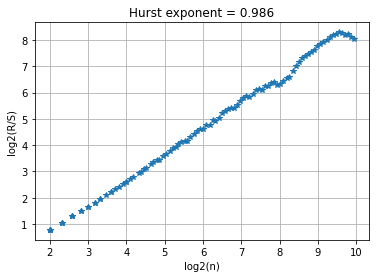

In [31]:
h, ns, ri = compute_hurst_exponent(prices_ts, 100)
print(f"h = {h}")
plt.plot(np.log2(ns), np.log2(ri), '*')
plt.xlabel("log2(n)")
plt.ylabel("log2(R/S)")
plt.title(f"Hurst exponent = {round(h,3)}")
plt.grid()
plt.savefig("hurst.png")
plt.show()


In [7]:
def create_dataset(prices, lag_size, lead_size):
    
    prices = prices.copy()

    lags = list(range(1, lag_size))
    for lag in lags:
        col_name = f"lag_{lag}" 
        prices[col_name] = prices['lag_0'].shift(lag)

    leads = list(range(1, lead_size + 1))
    for lead in leads:
        col_name = f"lead_{lead}" 
        prices[col_name] = prices['lag_0'].shift(-lead)

    prices.dropna(inplace = True)
    train_cols = [c for c in prices.columns if 'lag' in c][::-1]
    test_cols = [c for c in prices.columns if 'lead' in c]

    train_df = prices['2017-11-02':'2021-07-05']
    train_x =  train_df[train_cols]
    train_y =  train_df[test_cols]

    test_df = prices['2021-07-05':]
    test_x =  test_df[train_cols]
    test_y =  test_df[test_cols]

    return  train_x, train_y, test_x, test_y

In [8]:
mean = close_prices.mean().values
std = close_prices.std().values
standardized_prices = (close_prices - mean) / std

In [9]:
def flatten_lagged_matrix(mat):
    return np.concatenate([mat[:, 0][:-1], mat[-1, :]])

In [26]:
@dataclass
class Result:
    model: tf.keras.Model
    history: list
    train_x: np.ndarray
    train_y: np.ndarray
    test_y: np.ndarray
    test_x: np.ndarray
    train_y_pred: np.ndarray
    test_y_pred: np.ndarray
    lags: int
    leads: int

results = []
for i, model in enumerate([model1(), model2(), model3(), model4(), model5(), model6()]):
    print(f"training model {i + 1}")

    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse','mae'])

    train_x, train_y, test_x, test_y = create_dataset(
        standardized_prices, model.input_shape[1], model.output_shape[1])

    history = model.fit(train_x, train_y, validation_data=(test_x, test_y),
            epochs=300, verbose=False, batch_size=32)


    test_y_pred = model.predict(test_x)
    flat_test_y_pred = np.concatenate([test_y_pred[:, 0][:-1], test_y_pred[-1, :]])

    train_y_pred = model.predict(train_x)
    flat_train_y_pred = np.concatenate([train_y_pred[:, 0][:-1], train_y_pred[-1, :]])


    flat_train_y = np.concatenate([train_y.values[:, 0][:-1], train_y.values[-1, :]])
    flat_test_y = np.concatenate([test_y.values[:, 0][:-1], test_y.values[-1, :]])
    flat_train_x = train_x['lag_0'].values
    flat_test_x = test_x['lag_0'].values

    results.append(Result(
        model,
        history,
        flat_train_x,
        flat_train_y,
        flat_test_y,
        flat_test_x,
        flat_train_y_pred,
        flat_test_y_pred,
        model.input_shape[1], 
        model.output_shape[1]
    )) 


training model 1
training model 2
training model 3
training model 4
training model 5
training model 6


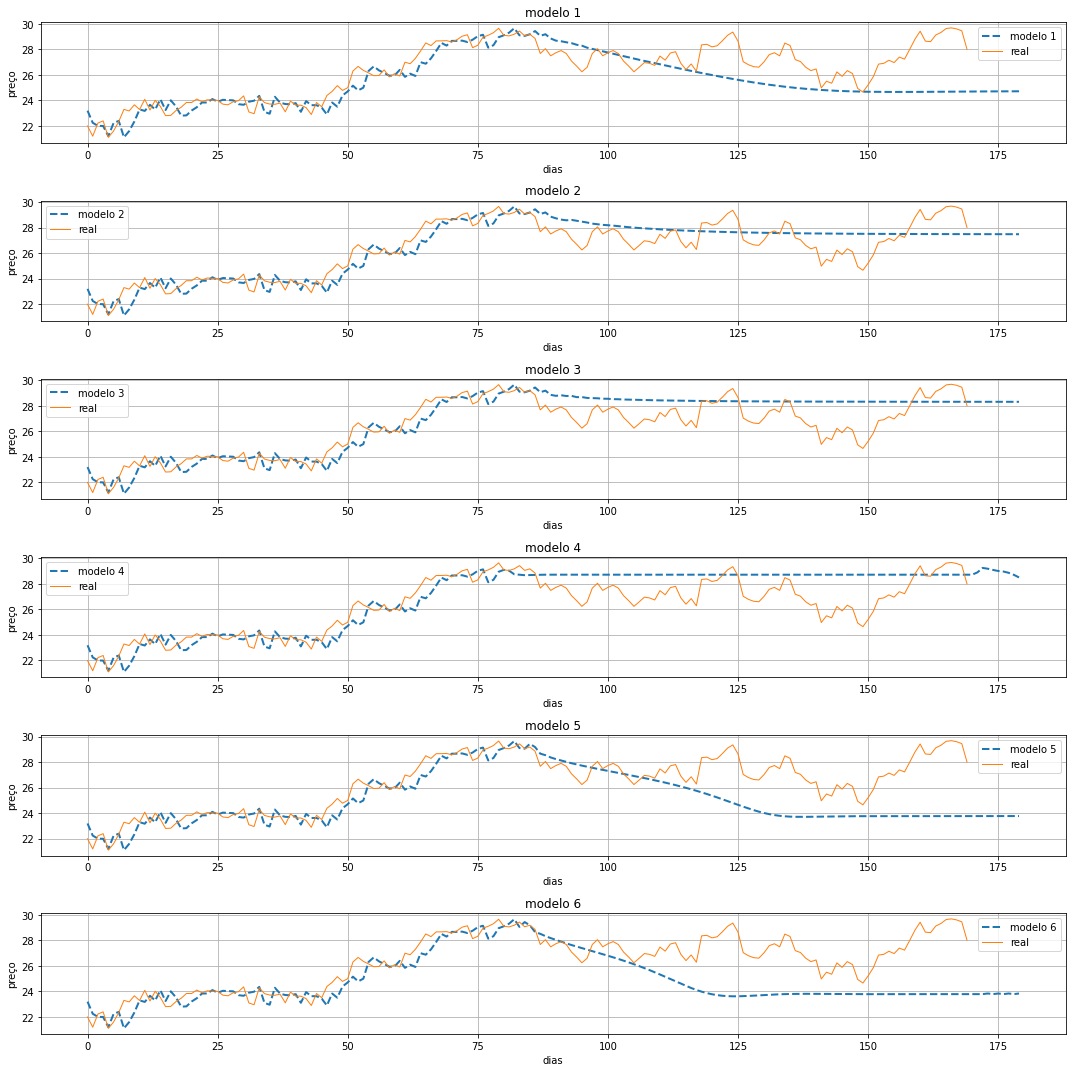

In [32]:
fig, axes = plt.subplots(6, 1, figsize=(15, 15))
for i, result in enumerate(results):
    m = results[i].model
    lags = results[i].lags
    leads = results[i].leads

    train_x, train_y, test_x, test_y = create_dataset(
        standardized_prices, m.input_shape[1], m.output_shape[1])

    tx = train_x.values
    # print(tx.shape)
    for _ in range(90):
        last_row = tx[[-1]]
        prediction = m.predict(last_row)
        new_row = np.hstack([last_row[:,leads:], prediction]) #, last_row, prediction
        tx = np.vstack([tx, new_row])
    # print(tx.shape)
    
    tx = flatten_lagged_matrix(tx)
    lasts = 180
    orig_curve = np.hstack([results[3].train_y, results[3].test_y[:90]])
    sns.lineplot(x = np.arange(len(tx[-lasts:])), y = tx[-lasts:] * std + mean, ax = axes[i], lw='2', ls='--', label = f"modelo {i+1}")
    sns.lineplot(x = np.arange(len(orig_curve[-lasts + 10:])), y = orig_curve[-lasts + 10:] * std + mean, ax = axes[i], lw='1', label = f"real")
    axes[i].grid(True)
    axes[i].set_title(f"modelo {i+1}")
    axes[i].set_xlabel("dias")
    axes[i].set_ylabel("preço")
plt.tight_layout()
plt.savefig("especulative_predictions.png")
plt.show()

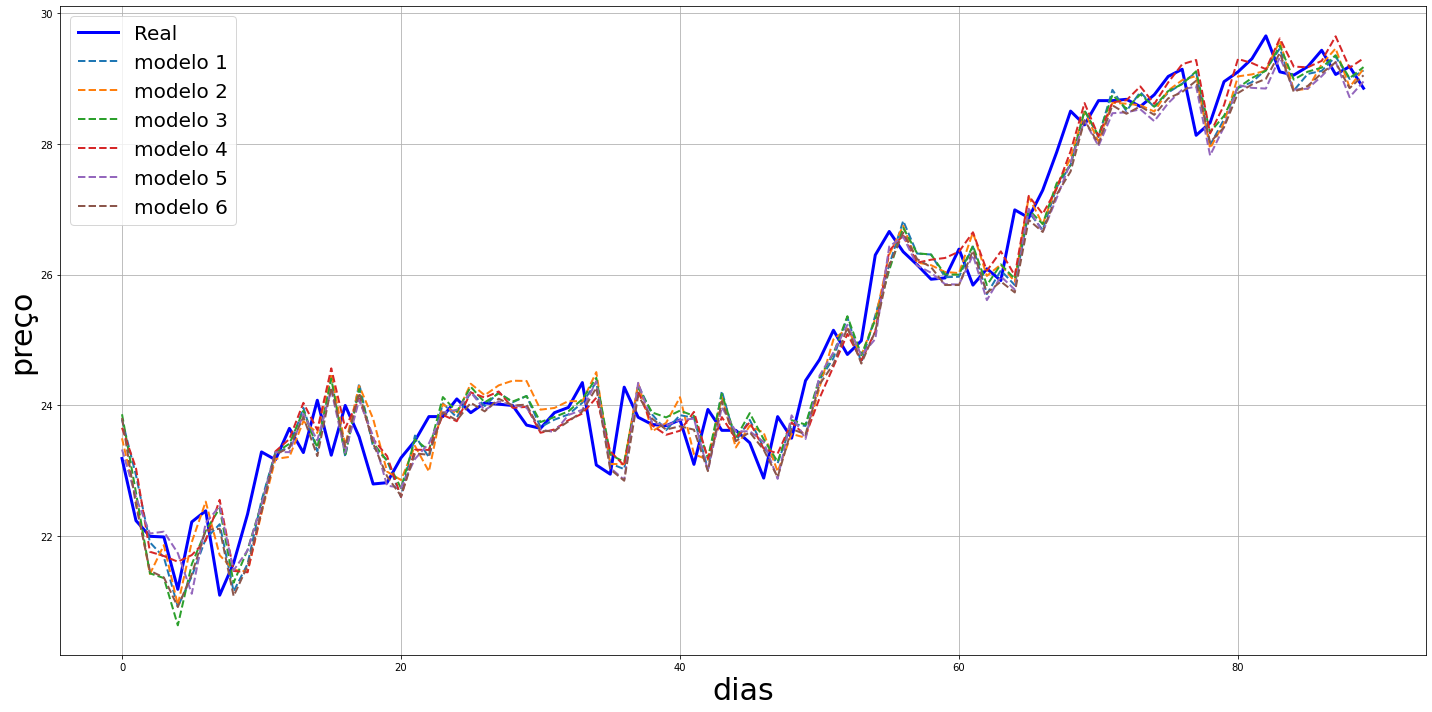

In [45]:
# fig, axes = plt.subplots(6, 1, figsize=(10, 15))
fig, ax = plt.subplots(figsize=(20, 10))
for i, r in enumerate(results):
    lasts = 90
    lasts_train_y = r.train_y[-lasts-r.leads:-r.leads]
    lasts_train_y_pred = r.train_y_pred[-lasts-r.leads:-r.leads]
    if i == 0:
        sns.lineplot(x = np.arange(len(lasts_train_y)), y = lasts_train_y * std + mean, ax = ax, lw='3', color = 'blue', label = 'Real')
    sns.lineplot(x = np.arange(len(lasts_train_y)), y = lasts_train_y_pred * std + mean, ax = ax, lw='2', ls='--', label = f"modelo {i+1}")

plt.legend( prop={'size': 20})
plt.grid()
plt.xlabel("dias", size=30)
plt.ylabel("preço", size=30)
plt.tight_layout()

plt.savefig("train_predictions.png")
plt.show()

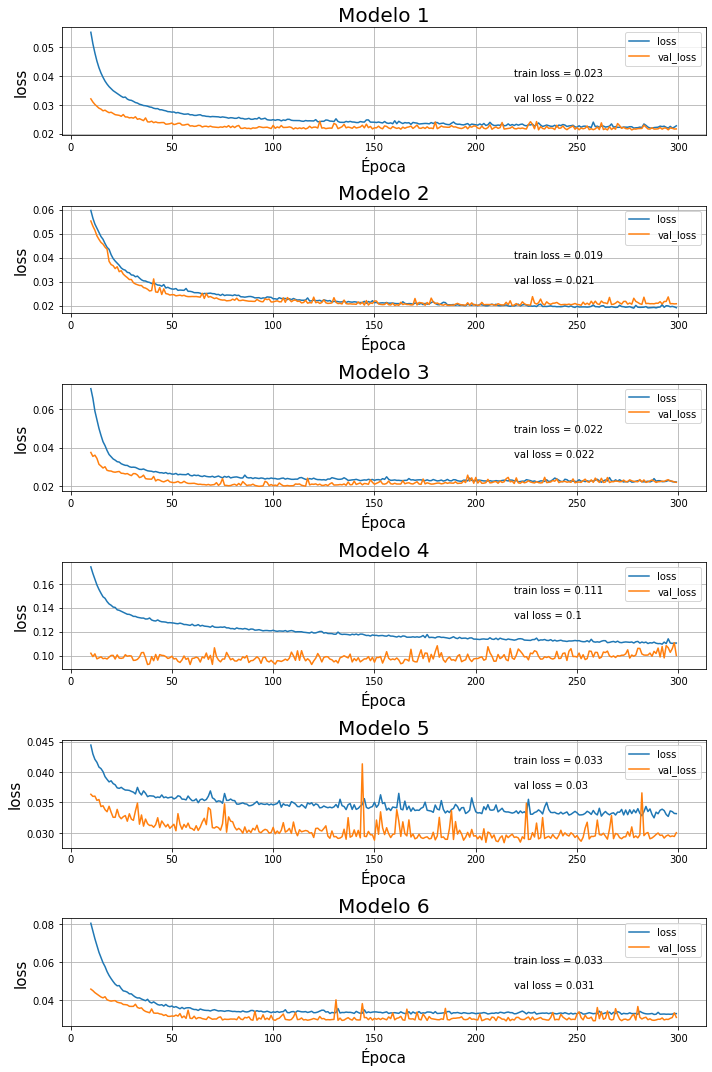

In [57]:
fig, axes = plt.subplots(6, 1, figsize=(10, 15))
for i, r in enumerate(results):
    sns.lineplot(x = r.history.epoch[10:], y = r.history.history['loss'][10:], ax = axes[i])
    sns.lineplot(x = r.history.epoch[10:], y = r.history.history['val_loss'][10:], ax = axes[i])
    annot_x = r.history.epoch[-1]
    annot_y = r.history.history['loss'][-1]
    annot_y_val = r.history.history['val_loss'][-1]
    axes[i].annotate(f"train loss = {round(annot_y, 3)}", (annot_x - 80, annot_y), xytext=(0, 50), textcoords='offset points')
    axes[i].annotate(f"val loss = {round(annot_y_val, 3)}", (annot_x - 80, annot_y), xytext=(0, 25), textcoords='offset points')

    axes[i].set_title(f"Modelo {i + 1}", size = 20)
    axes[i].set_xlabel("Época", size = 15)
    axes[i].set_ylabel("loss", size = 15)
    axes[i].legend(['loss', 'val_loss'])
    axes[i].grid(True)

plt.tight_layout()
plt.savefig("loss.png")
plt.show()

  model 1:
                    error mean: -5.229557962249444e-05
                    error std:  0.14703797564812898
  model 2:
                    error mean: 0.007316878454768823
                    error std:  0.1369432693501244
  model 3:
                    error mean: 0.009868131965212369
                    error std:  0.1476783914593398
  model 4:
                    error mean: 0.019755517377072648
                    error std:  0.1528908900624468
  model 5:
                    error mean: -0.0021165550270298298
                    error std:  0.1511483567877303
  model 6:
                    error mean: -0.01689197449909897
                    error std:  0.14965708994331187


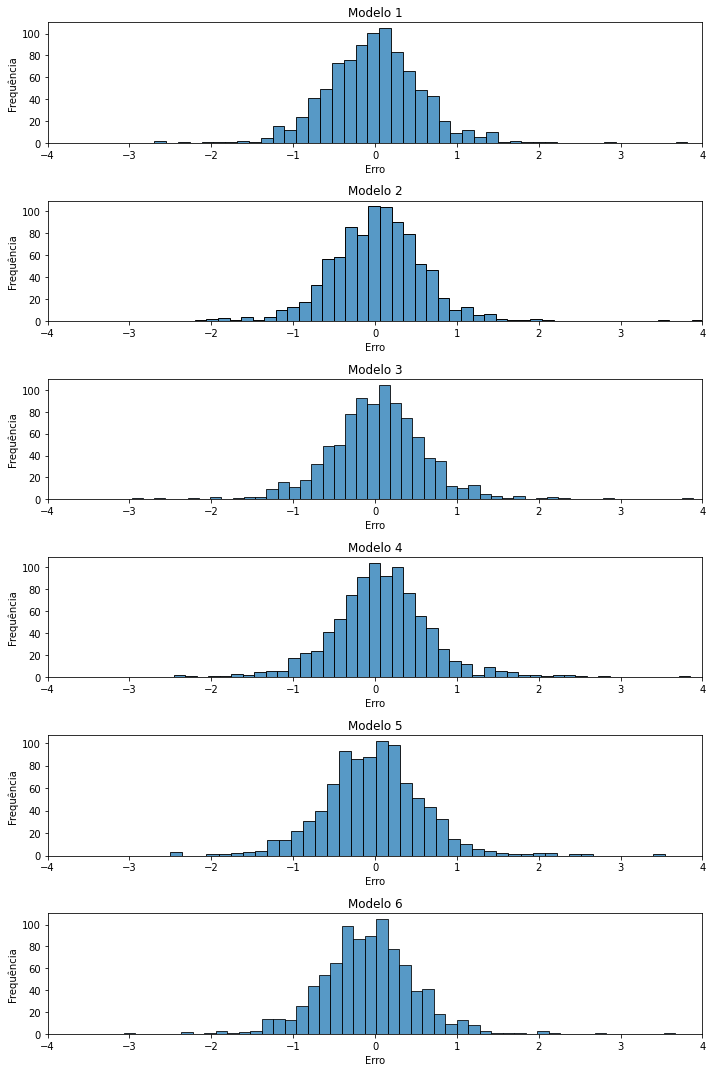

In [60]:
fig, axes = plt.subplots(6, 1, figsize=(10, 15))
for i, r in enumerate(results):
    # sns.lineplot(x = np.arange(len(r.train_y)), y = r.train_y * std + mean, ax = axes[i])
    errors = r.train_y_pred - r.train_y 
    # sns.lineplot(x = np.arange(len(r.train_y)), y = errors * std, ax = axes[i], linestyle = '--')
    sns.histplot(errors * std, ax = axes[i])
    print(f"""  model {i + 1}:
                    error mean: {np.mean(errors)}
                    error std:  {np.std(errors)}""")

    axes[i].set_xlim(-4, 4)
    axes[i].set_title(f"Modelo {i + 1}")
    axes[i].set_xlabel("Erro")
    axes[i].set_ylabel("Frequência")

plt.tight_layout()
plt.savefig("errors.png")
plt.show()